## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
x, c = shortestpath.genData(n, p, grid)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 309.10it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 327.93it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from loss import SPOPlusLoss

In [16]:
# init SPO+ loss
criterion = SPOPlusLoss()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [19]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

## Training 

In [20]:
from matplotlib import pyplot as plt

In [21]:
# set optimizer
optimizer = torch.optim.SGD(lr.parameters(), lr=1e-2)

In [22]:
# train model
num_epochs = 300
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if epoch % 2 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch, loss.item()))

epoch 0, loss:4.968954
epoch 2, loss:5.066632
epoch 4, loss:4.735860
epoch 6, loss:3.798617
epoch 8, loss:3.063192
epoch 10, loss:4.091363
epoch 12, loss:3.745046
epoch 14, loss:4.011820
epoch 16, loss:3.188916
epoch 18, loss:2.484494
epoch 20, loss:2.283013
epoch 22, loss:3.507820
epoch 24, loss:2.629464
epoch 26, loss:2.781667
epoch 28, loss:2.513170
epoch 30, loss:2.509434
epoch 32, loss:2.324235
epoch 34, loss:2.235128
epoch 36, loss:2.031625
epoch 38, loss:1.840861
epoch 40, loss:1.560399
epoch 42, loss:2.197098
epoch 44, loss:2.294854
epoch 46, loss:2.134630
epoch 48, loss:1.674926
epoch 50, loss:2.250634
epoch 52, loss:1.671576
epoch 54, loss:1.593022
epoch 56, loss:1.400938
epoch 58, loss:1.777177
epoch 60, loss:0.893590
epoch 62, loss:1.025010
epoch 64, loss:1.541057
epoch 66, loss:0.907567
epoch 68, loss:1.138508
epoch 70, loss:1.163516
epoch 72, loss:0.944490
epoch 74, loss:0.791288
epoch 76, loss:1.096502
epoch 78, loss:1.073910
epoch 80, loss:1.147915
epoch 82, loss:1.1367

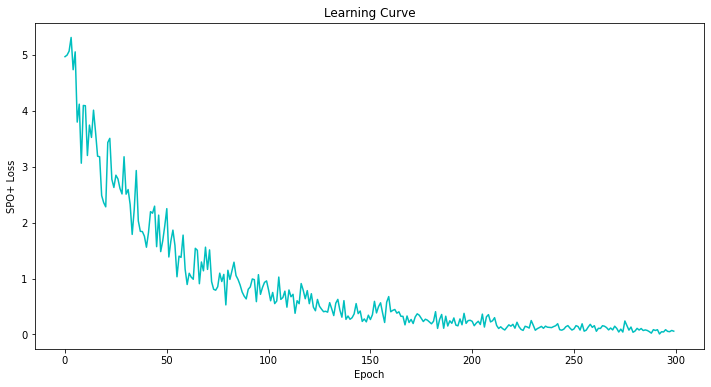

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np

In [25]:
# evaluate
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    loss.append(criterion.apply(sp_model, cp, c, w, z).mean().item())
print('Test Loss: {:.6f}'.format(np.mean(loss)))

Test Loss: 0.078918


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 3.56, 2.73, 2.34, 3.59, 2.70, 3.34, 2.62, 2.36, 3.81, 2.84, 3.34, 2.84, 3.23, 2.36, 3.71, 2.36, 2.87, 2.12, 1.64, 3.34, 2.84, 2.12, 2.47, 3.21, 3.06, 2.62, 3.71, 3.71, 1.86, 2.95, 1.75, 3.23, 1.75, 2.73, 2.34, 2.95, 2.62, 2.95, 2.00, 2.12
    Pred cost: 0.48, 0.78, -0.78, -0.29, -0.65, 1.15, 0.16, 1.17, 0.74, 0.63, 0.77, -1.33, 1.27, 0.12, 0.76, -0.53, -0.56, 0.08, -1.48, 0.62, -1.14, 0.42, 0.64, -0.49, -0.15, -0.02, 1.53, -0.71, -0.40, -0.45, 0.52, -0.85, -0.45, 0.09, 0.85, 0.43, -0.08, 0.62, -0.18, -0.21
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 18.61
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 18.61

Sample 1:
    True cost: 0.61, 1.95, 2.34, 1.30, 1.26, 0.45, 0.68, 1.08, 1.46, 1.97, 0.45, 0.83, 0.44, 1.08, 1.32, 1.08, 1.52, 2.19, 1.30, 0.45, 0.83, 2.19, 1.10,

##  Training with Regularization

In [27]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.SGD(lr.parameters(), lr=1e-2)

In [ ]:
# train model
num_epochs = 300
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l2 loss
        l2_lambda = 1e-2
        l2_reg = torch.tensor(0.).cuda()
        for param in lr.parameters():
            l2_reg += torch.norm(param) / 2
        loss += l2_lambda * l2_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if epoch % 2 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch, loss.item()))

epoch 0, loss:7.350955
epoch 2, loss:6.241418
epoch 4, loss:5.236830
epoch 6, loss:4.941387
epoch 8, loss:5.610991
epoch 10, loss:5.812463
epoch 12, loss:5.142009
epoch 14, loss:4.983010
epoch 16, loss:4.605390
epoch 18, loss:3.561493
epoch 20, loss:4.107893
epoch 22, loss:3.713592
epoch 24, loss:3.842472
epoch 26, loss:2.735312
epoch 28, loss:2.853134
epoch 30, loss:2.855982
epoch 32, loss:3.171876
epoch 34, loss:2.551890
epoch 36, loss:2.625046
epoch 38, loss:2.635846
epoch 40, loss:2.611126
epoch 42, loss:1.987548
epoch 44, loss:2.136506
epoch 46, loss:1.494443
epoch 48, loss:1.392295
epoch 50, loss:1.649987
epoch 52, loss:1.372666
epoch 54, loss:1.423691
epoch 56, loss:1.381362
epoch 58, loss:1.256042
epoch 60, loss:1.076947
epoch 62, loss:0.692557
epoch 64, loss:0.863875
epoch 66, loss:0.735409
epoch 68, loss:0.997701
epoch 70, loss:0.729741
epoch 72, loss:0.348737
epoch 74, loss:0.885583
epoch 76, loss:0.785973
epoch 78, loss:0.539768
epoch 80, loss:0.835919
epoch 82, loss:0.6767

In [ ]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [ ]:
# evaluate
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    loss.append(criterion.apply(sp_model, cp, c, w, z).mean().item())
print('Test Loss: {:.6f}'.format(np.mean(loss)))

In [ ]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break